# visualization

> Functions for visualizing rasters, shapefiles, and results.

In [ ]:
#| default_exp visualization

In [ ]:
#| hide
from nbdev.showdoc import *

/Users/alice/miniforge3/envs/muir-dev/lib/python3.10/site-packages/nbdev/doclinks.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources,importlib


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
import rasterio
import numpy as np
import pandas as pd
import geopandas as gpd
import yaml
import os

In [ ]:
from muir.core import get_demo_path, load_config

In [ ]:
config_path = get_demo_path("configs/preprocessing/preprocess-demo.yaml")
conf = load_config(config_path)

## Layer Visualizations

In [ ]:
#| export

import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_raster_with_shape(
    raster_path: str,
    shape_paths,  # Can be a str or a list of str
    ax: plt.Axes = None,
    cmap: str = 'gray',
    shape_colors=None,
    alpha: float = 0.5,
    legend: bool = True,
    highlight_nodata=False
):
    if isinstance(shape_paths, str):
        shape_paths = [shape_paths]
    if shape_colors is None:
        # Default color cycle
        shape_colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan']
    with rasterio.open(raster_path) as src:
        img = src.read(1)
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
        raster_crs = src.crs
        nodata = src.nodata

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))

    if highlight_nodata:
        if nodata is not None:
            img = np.where(img == nodata, 1, 0)
            cmap = 'gray'
        nodata_patch = mpatches.Patch(color='white', label='NoData')
        ax.legend(handles=[nodata_patch], loc='upper right', fontsize=16)
    
    ax.imshow(img, extent=extent, cmap=cmap)

    handles = []
    labels = []
    for i, shape_path in enumerate(shape_paths):
        color = shape_colors[i % len(shape_colors)]
        shape_gdf = gpd.read_file(shape_path)
        shape_gdf = shape_gdf.to_crs(raster_crs)
        # Plot and get the handle for legend
        handle = shape_gdf.boundary.plot(ax=ax, color=color, linewidth=2, alpha=alpha, label=shape_path)
        handles.append(handle)
        labels.append(Path(shape_path).stem)

    if legend and len(shape_paths) > 1:
        ax.legend(labels, loc='upper right')
    plt.show()


In [ ]:
#| export

import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt

def plot_shapes(
    shape_paths,  # Can be a str or a list of str
    ax: plt.Axes = None,
    shape_colors=None,
    alpha: float = 0.5,
    legend: bool = True
):
    if isinstance(shape_paths, str):
        shape_paths = [shape_paths]
    if shape_colors is None:
        shape_colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan']
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))

    labels = []
    for i, shape_path in enumerate(shape_paths):
        color = shape_colors[i % len(shape_colors)]
        shape_gdf = gpd.read_file(shape_path)
        shape_gdf.boundary.plot(ax=ax, color=color, linewidth=2, alpha=alpha, label=shape_path)
        labels.append(Path(shape_path).stem)

    if legend and len(shape_paths) > 1:
        ax.legend(labels, loc='upper right')
    plt.show()


In [ ]:
#| export

def highlight_nodata(raster_path, shape_paths):
    plot_raster_with_shape(
        raster_path=raster_path,
        shape_paths=shape_paths,
        highlight_nodata=True
    )

In [ ]:
#| export

from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt

def plot_raster(
    raster_path: str,        # path to the raster file
    clr_path: str = None,    # optional path to a .clr file for color mapping
    ax: plt.Axes = None,     # optional matplotlib Axes to plot on
    title: str = None,       # optional plot title
    show_colorbar: bool = True  # whether to show colorbar (default True)
):
    """
    Plot a raster using matplotlib. Optionally use a .clr file for LULC color mapping.
    """
    with rasterio.open(raster_path) as src:
        img = src.read(1)
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
        nodata = src.nodata

    # Mask nodata for display
    if nodata is not None:
        img = np.ma.masked_equal(img, nodata)

    if clr_path:
        # Parse clr file for color mapping
        clr_df = parse_clr(clr_path)
        # Ensure class values are sorted for BoundaryNorm
        class_values = np.sort(clr_df['class'].values)
        colors = clr_df.set_index('class').loc[class_values, 'color_hex'].values
        cmap = ListedColormap(colors)
        # Add one more bin edge above the last class for BoundaryNorm
        norm = BoundaryNorm(np.append(class_values, class_values[-1]+1), cmap.N)
        imshow_args = dict(cmap=cmap, norm=norm)
    else:
        imshow_args = dict(cmap='viridis')

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))

    im = ax.imshow(img, extent=extent, **imshow_args)
    if title:
        ax.set_title(title)
    if show_colorbar:
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.show()


We can plot a raster and shapefile.

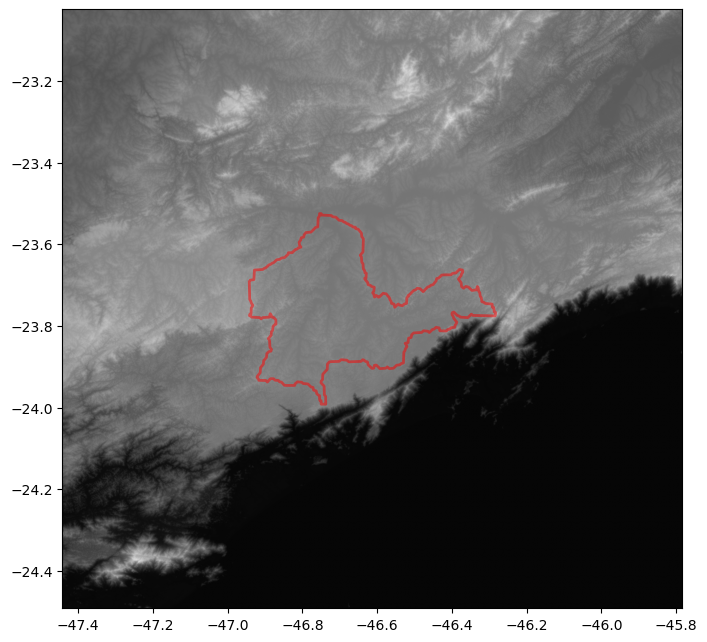

In [ ]:
plot_raster_with_shape(
    conf["rasters"]["dem"]["raw_path"],
    [conf["vectors"]["aoi"]["raw_path"]]
)

## LULC

In [ ]:
#| export
def parse_clr(lulc_clr_path):
    records = []
    with open(lulc_clr_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 6:
                continue  # skip malformed lines
            class_ = int(parts[0])
            r, g, b = map(int, parts[1:4])
            class_name = " ".join(parts[5:])
            color_rgb = (r, g, b)
            color_hex = "#{:02x}{:02x}{:02x}".format(r, g, b)
            records.append({
                "class": class_,
                "color_rgb": color_rgb,
                "color_hex": color_hex,
                "class_name": class_name
            })
    df = pd.DataFrame(records)
    return df

## Heatmaps

In [ ]:
#| export
from fastcore.test import *

import pygeoprocessing
import pandas as pd
import geopandas as gpd
import numpy as np
import math
from osgeo import gdal
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import Normalize, BoundaryNorm
from matplotlib_map_utils.core.scale_bar import ScaleBar, scale_bar
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

In [ ]:
#| export
def get_zonal_stats(
    stats_raster_path: str,
    zones_vector_path: str,
    raster_band:int=1
) -> gpd.GeoDataFrame:
    # Computes min, max, sum, count, nodata_count - and later mean
    stats_dict = pygeoprocessing.zonal_statistics(
        base_raster_path_band=(stats_raster_path, raster_band),
        aggregate_vector_path=zones_vector_path
    )
    stats_df = pd.DataFrame.from_dict(stats_dict, orient='index')
    stats_df = stats_df.sort_index()
    stats_df["mean"] = stats_df["sum"] / stats_df["count"]

    # Load zones
    zones_df = gpd.read_file(zones_vector_path)
    zones_df = zones_df.sort_index()

    # Merge stats into one
    gdf = zones_df.join(stats_df)

    return gdf

In [ ]:
#| export
def gdf_heatmap(
    gdf: gpd.GeoDataFrame, # GeoPandas dataframe with at least `GEOMETRY` and `stat` columns
    stat: str,
    reverse_cmap: bool = False,
    cmap_scale: str = "quantile",  # or "linear"
    nbins: int = 100,
    title: str = None,
    legend_labels: list[str] | None = None,
    legend_title: str | None = None,
    legend_cmap_scale: bool = False,
    save_path: Path = None,
    **kwargs
):
    data = gdf[stat]
    
    cmap_name = "Greens_r" if reverse_cmap else "Greens"
    cmap = plt.get_cmap(cmap_name)

    if cmap_scale == "quantile":
        bins = np.percentile(data, np.linspace(0, 100, nbins + 1))
        norm = BoundaryNorm(bins, ncolors=256, clip=True)
    elif cmap_scale == "linear":
        norm = Normalize(vmin=data.min(), vmax=data.max())
        bins = None
    else:
        raise ValueError("cmap_scale must be 'quantile' or 'linear'")

    fig = plt.figure(figsize=(12, 4), dpi=300)
    gs = GridSpec(1, 2, width_ratios=[5, 1], figure=fig)

    ax_map = fig.add_subplot(gs[0])
    ax_info = fig.add_subplot(gs[1])

    gdf.plot(
        column=stat,
        cmap=cmap,
        norm=norm,
        legend=False,
        edgecolor='black',
        linewidth=0.5,
        ax=ax_map,
        **kwargs
    )
    ax_map.set_axis_off()

    # Add Scalebar
    ScaleBar.set_size("small")
    scale_bar(ax_map, location="lower right", style="boxes", bar={"projection": gdf.crs})

    # Add Legend
    if legend_labels is None:
        if reverse_cmap:
            legend_labels = ["High Reduction", "Medium Reduction", "Low Reduction"]
        else:
            legend_labels = ["Low Increase", "Medium Increase", "High Increase"]
    if bins is not None:
        low, mid, high = bins[0], bins[len(bins)//2], bins[-1]
    else:
        low, mid, high = data.min(), (data.min() + data.max())/2, data.max()
    colors = [cmap(norm(x)) for x in (low, mid, high)]
    legend_patches = [mpatches.Patch(color=c, label=l) for c, l in zip(colors, legend_labels)]
    ax_info.set_axis_off()

    if legend_cmap_scale:
        footer = Line2D([], [], linestyle='None', marker='', label=f"Colormap scale: {cmap_scale}")
        handles = legend_patches + [footer]
    else:
        handles = legend_patches
    legend = ax_info.legend(
        handles=handles, 
        title=legend_title or None, 
        loc='center left', 
    )

    # Make the footer italic and indented
    if legend_cmap_scale:
        legend_texts = legend.get_texts()
        footer_text = legend_texts[-1]
        footer_text.set_fontstyle('italic')
        footer_text.set_horizontalalignment('left')
        footer_text.set_x(-110)

    # Add Title
    if title:
        ax_map.set_title(title, fontsize=16)

    # Add CRS Text
    ax_map.text(
        1, -0.02,
        f"CRS: {gdf.crs.to_string()}",
        transform=ax_map.transAxes,
        ha='right',
        va='bottom',
        fontsize=8,
    )

    # Display
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()